Importing necessary libraries

In [27]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
#from sklearn.preprocessing import StandardScaler

from keras.utils import plot_model
from tensorflow.keras.metrics import Recall
#from sklearn.metrics import classification_report,confusion_matrix

from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Recall
#from sklearn.metrics import classification_report,confusion_matrix

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

import pickle

# The Dataset



HAM10000_metadata.csv file is the main csv file that includes the data of all training images, the features of which are -
1. Lesion_id
2. Image_id
3. Dx
4.  Dx_type
5.  Age
6.  Sex
7.  Localization



In [28]:
# Reading the data from HAM_metadata.csv
df = pd.read_csv('./archive/HAM10000_metadata.csv')

In [29]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [30]:
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [31]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


A statistical analysis of numerical attributes of the dataset (age)

### Data Cleaning and Management

Removing NULL values from the dataset

In [32]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

There are 57 NULL values in 'age' feature.
Rather than dropping the values, replacing NULL values with the mean of 'age'.

In [33]:
df['age'].fillna( df['age'].mean()  , inplace = True)

In [34]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

All NULL values are now resolved.

Now, Making a lesion type dictionary to map the lesion type to a dataframe column.

In [35]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

base_skin_dir = './archive'

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [36]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./archive\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./archive\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./archive\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./archive\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./archive\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2


# Image Preprocessing

We have to resize the images from dimensions : 400 * 600 * 3 to dimensions : 75 * 60 * 3 as the model might take a lot of time to run on large dimensions of images.

In [37]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((75,60))))

Plotting some images from each class of dataset.

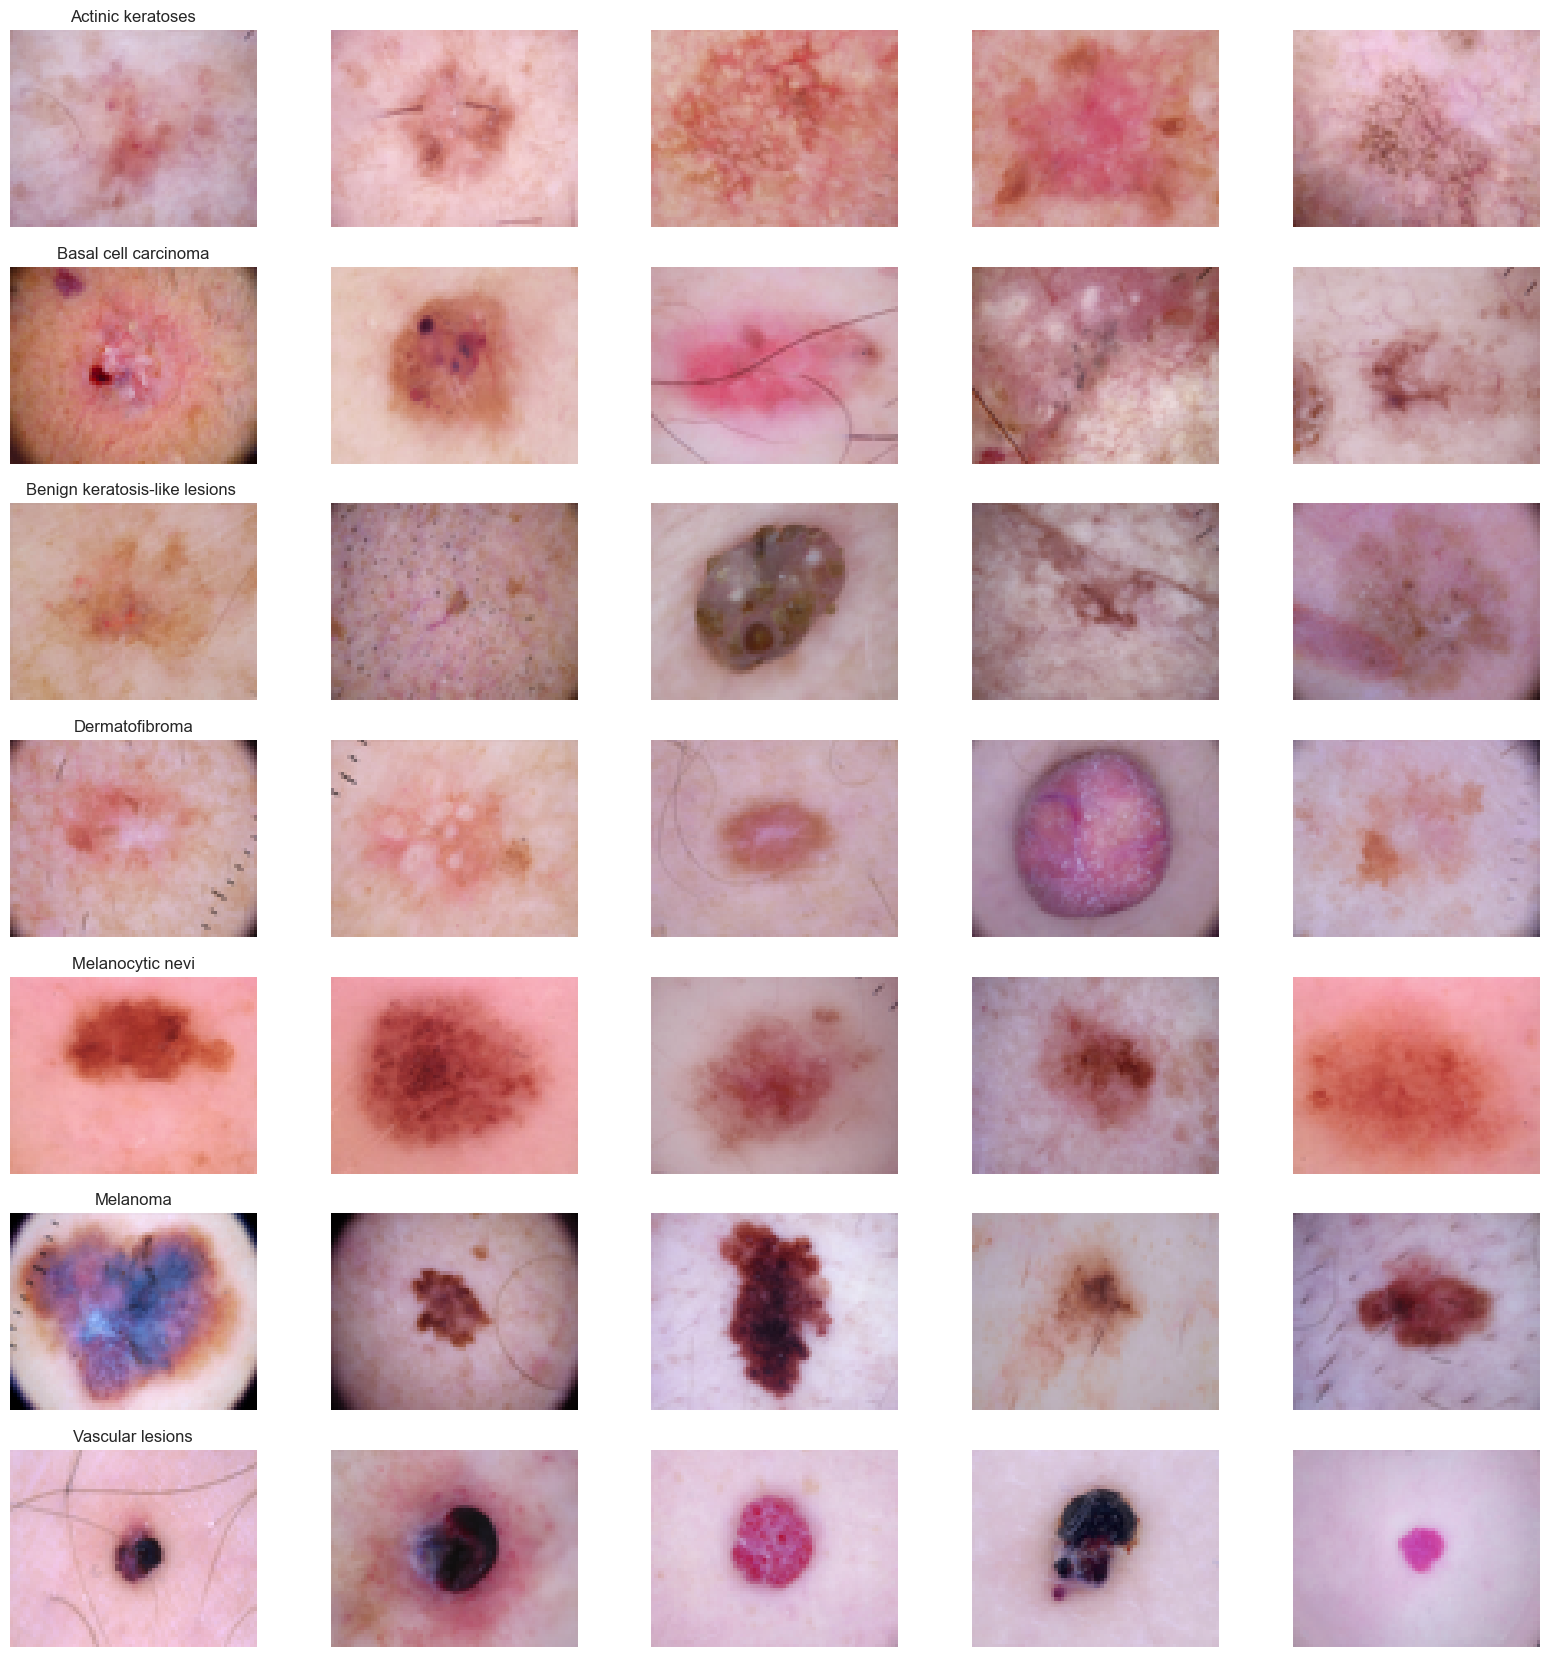

In [38]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [39]:
# to check the image size distribution - It returns one row that shows all images are uniform
df['image'].map(lambda x: x.shape).value_counts()

image
(60, 75, 3)    10015
Name: count, dtype: int64

In [40]:
features = df.drop(columns = ['cell_type_idx'], axis = 1)
target = df['cell_type_idx']

features.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./archive\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,"[[[191, 151, 194], [191, 153, 194], [192, 151,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./archive\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,"[[[23, 13, 23], [24, 14, 26], [31, 19, 38], [4..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./archive\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,"[[[185, 128, 139], [190, 134, 149], [197, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./archive\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,"[[[23, 11, 18], [32, 17, 27], [54, 31, 42], [7..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./archive\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,"[[[138, 94, 117], [154, 109, 134], [171, 127, ..."


In [41]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=666)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Melanocytic nevi', b'Basal cell carcinoma', b'Melanoma',
       b'Vascular lesions', b'Benign keratosis-like lesions ',
       b'Actinic keratoses', b'Dermatofibroma'], dtype=object)>, idx=<tf.Tensor: shape=(7511,), dtype=int32, numpy=array([0, 1, 0, ..., 1, 0, 0])>)

In [42]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [43]:
# Performing one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [44]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)

# Reshaping images in 3 dimensions (height = 60, width = 75 , channel = 3)
x_train = x_train.reshape(x_train.shape[0], *(60, 75, 3))
x_test = x_test.reshape(x_test.shape[0], *(60, 75, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(60, 75, 3))

In [45]:
np.ma.shape(x_train)

(6759, 60, 75, 3)

In [46]:
np.ma.shape(x_test)

(2504, 60, 75, 3)

In [47]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [48]:
np.ma.shape(x_train)

(6759, 60, 75, 3)

# Implementation of CNN

The CNN model : DenseNet 121

Optimizer: SGD

Activation function used: Softmax

In [49]:
num_classes = 7
from keras.optimizers import SGD
input_shape = (60,75,3)

from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# DenseNet121
model = Sequential()
model.add(DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

ModuleNotFoundError: No module named 'keras.utils.vis_utils'

In [50]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [51]:
# # Fit the model
epochs = 10
batch_size=32
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

Epoch 1/10
212/212 [==============================] - 273s 1s/step - loss: 0.8390 - accuracy: 0.7097 - val_loss: 0.7343 - val_accuracy: 0.7566 - lr: 0.0010
Epoch 2/10
212/212 [==============================] - 263s 1s/step - loss: 0.5766 - accuracy: 0.7921 - val_loss: 0.6162 - val_accuracy: 0.7779 - lr: 0.0010
Epoch 3/10
212/212 [==============================] - 263s 1s/step - loss: 0.4514 - accuracy: 0.8350 - val_loss: 0.6076 - val_accuracy: 0.7832 - lr: 0.0010
Epoch 4/10
212/212 [==============================] - 263s 1s/step - loss: 0.3416 - accuracy: 0.8741 - val_loss: 0.5916 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 5/10
212/212 [==============================] - 264s 1s/step - loss: 0.2517 - accuracy: 0.9121 - val_loss: 0.7000 - val_accuracy: 0.7939 - lr: 0.0010
Epoch 6/10
212/212 [==============================] - 269s 1s/step - loss: 0.1941 - accuracy: 0.9303 - val_loss: 0.7644 - val_accuracy: 0.7926 - lr: 0.0010
Epoch 7/10
212/212 [==============================] - 265s 1s/st

212/212 [==============================] - 61s 272ms/step


ValueError: x and y must have same first dimension, but have shapes (6759, 60, 75, 3) and (47313,)

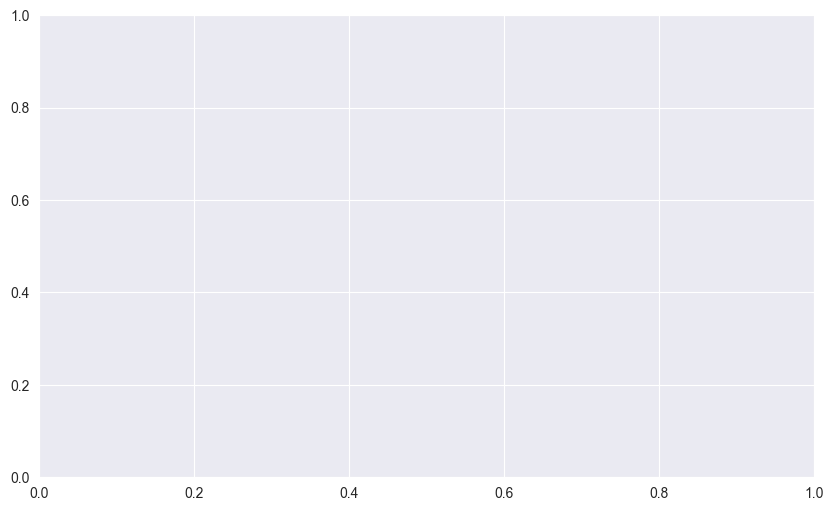

In [56]:
train_predictions = model.predict(x_train).flatten()

plt.figure(figsize = (10,6))
plt.plot(x_train, train_predictions)
plt.plot(x_train, y_train)
plt.xlabel('features')
plt.ylabel('Target')
plt.legend(['Training Predictions', 'Training Observations'])

Saving the model as a pickle file

In [52]:
import pickle
cnn_model_file = 'cnn_model.pkl'

pickle.dump(model, open(cnn_model_file, 'wb'))